In [1]:
%load_ext autoreload

from classification import IVT, IDT, IMST, IHMM, IKF, I2MC, NSLR_HMM, ISF

from jupyterthemes import jtplot
import matplotlib.pyplot as plt
jtplot.style(theme='monokai', context='paper', fscale=1.6, spines=False, gridlines='--')

import pandas as pd
import numpy as np

# Load Test Data

In [2]:
gaze = pd.read_csv('test/gaze_data.csv')
eye = pd.read_csv('test/eye_data.csv')
eye.head(3)

,t,x_right,x_left,y_right,y_left
0,0.000000,3.006280,5.586410,5.387228,5.286748
1,0.002508,3.233791,5.578731,5.219279,5.127462
2,0.004834,3.238093,6.129147,5.316068,5.203123


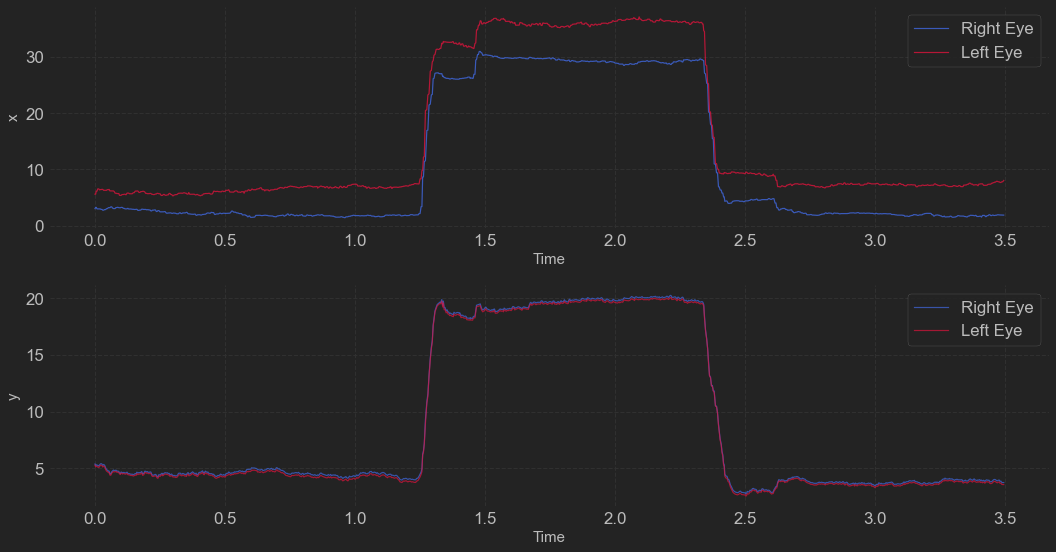

In [3]:
f, axes = plt.subplots(2, 1, figsize=(15, 8))

axes[0].plot(eye['t'], eye['x_right'], c='royalblue', alpha=0.8, label='Right Eye')
axes[0].plot(eye['t'], eye['x_left'], c='crimson', alpha=0.8, label='Left Eye')
axes[0].set_ylabel('x', fontsize=15)


axes[1].plot(eye['t'], eye['y_right'], c='royalblue', alpha=0.7, label='Right Eye')
axes[1].plot(eye['t'], eye['y_left'], c='crimson', alpha=0.7, label='Left Eye')
axes[1].set_ylabel('y', fontsize=15)
    
for ax in axes:
    ax.set_xlabel('Time', fontsize=15)
    ax.legend()
plt.tight_layout()
plt.show()

# Classification Tests 

## IVT

First described in _Salvucci and Goldberg (2000)_. Each sampled is classified as either a fixation or a saccade using a threshold value on the signal's velocity.

In [4]:
t = eye['t']
x = eye['x_right']
y = eye['y_right']

In [5]:
%autoreload

classifier = IVT(t, x, y, threshold=45)
classifier.process()

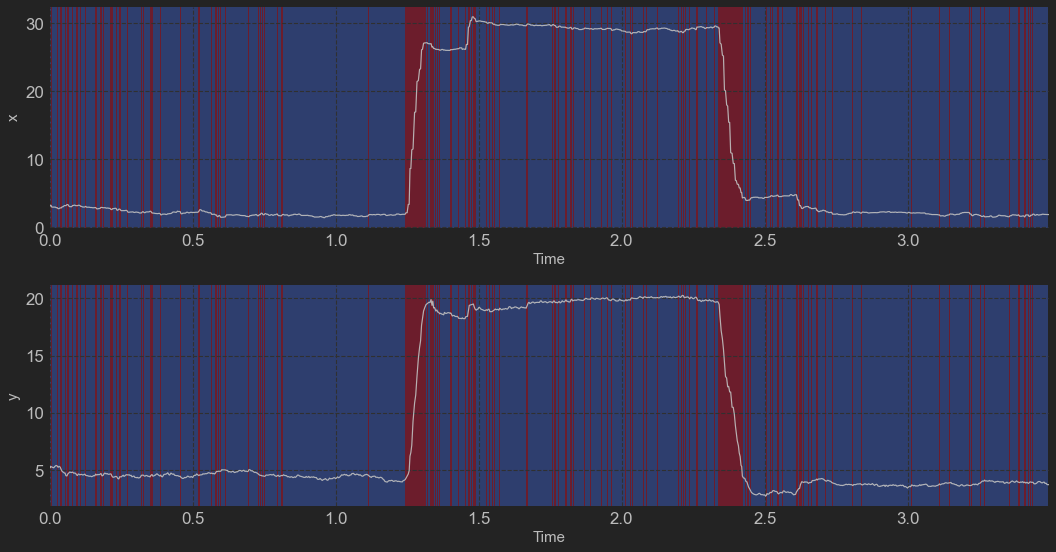

In [6]:
classifier.plot()

## IDT

First described in _Salvucci and Goldberg (2000)_. The algorithm defines a temporal window which moves one point at a time and the spacial dispersion created by the points within this window is compared against the threshold. If such dispersion is below the threshold, the points within the temporal window are classified as a part of fixation; otherwise, the window is moved by one sample, and the first sample of the previous window is classified as a saccade.

In [7]:
t = eye['t']
x = eye['x_right']
y = eye['y_right']

In [8]:
%autoreload

classifier = IDT(t, x, y, threshold=2, window_size=20)
classifier.process()

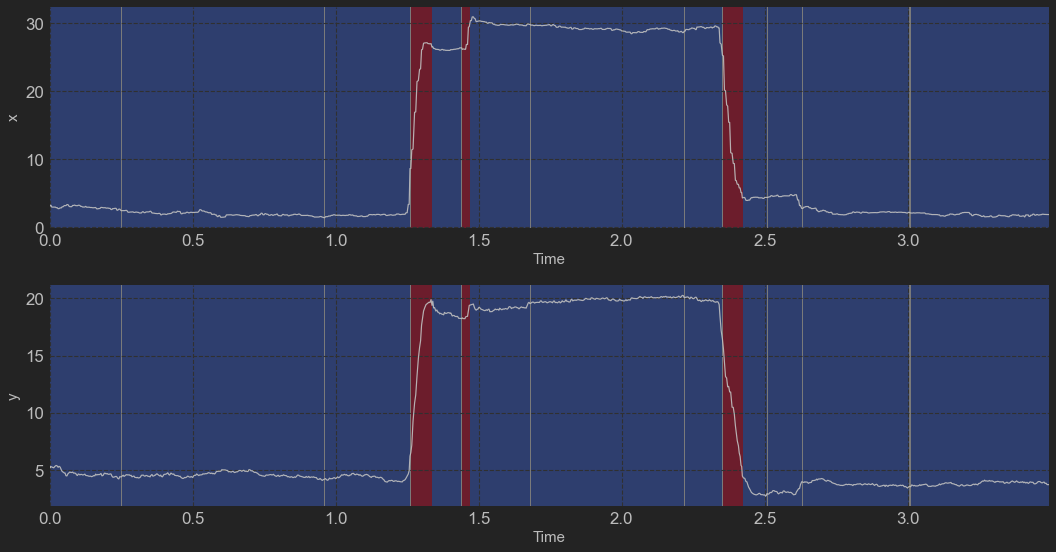

In [9]:
classifier.plot()

## IMST

First described in _Salvucci and Goldberg (2000)_. The I-MST is a dispersion-based identification algorithm that builds a minimum spanning tree taking a predefined number of eye position points using Prim's algorithm. The I-MST traverses the MST and separates the points into fixations and saccades based on the predefined distance thresholds. The I-MST requires a sampling window to build a sequence of MST trees allowing it to parse a long eye movement recording. Here, the window selected is 200ms.

In [10]:
t = eye['t']
x = eye['x_right']
y = eye['y_right']

In [11]:
%autoreload

classifier = IMST(t, x, y, threshold=0.2, window_size=200)
classifier.process()

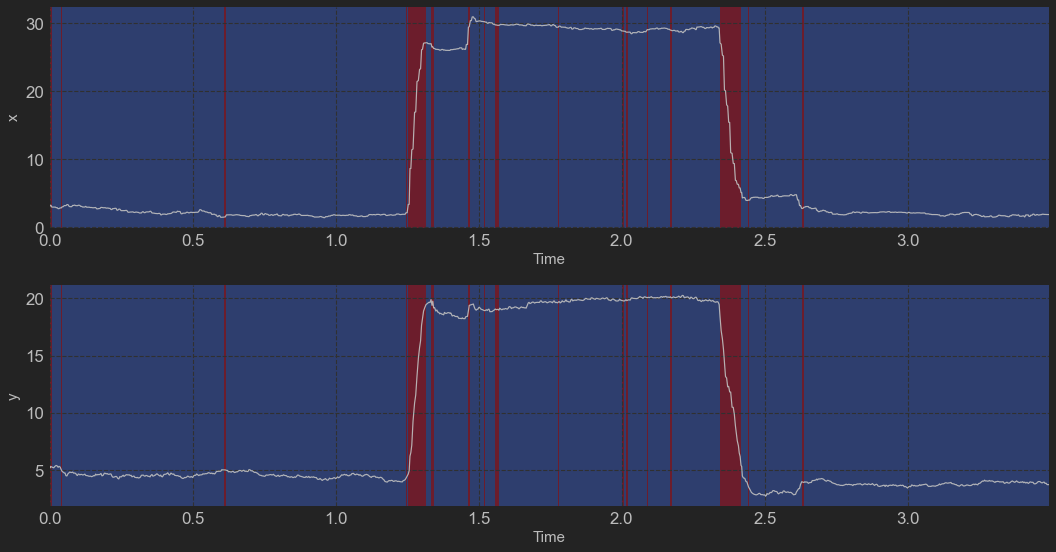

In [12]:
classifier.plot()

## IHMM

First described in *Salvucci and Goldberg (2000)*. The first stage of the I-HMM is identical to I-VT, where each eye position sample is classified either as a fixation or a saccade depending on the velocity threshold. Second stage is defined by the Viterbi Sampler (*Forney (1973)*), where each eye position can be re-classified, depending on the probabilistic parameters (initial state, state transition and observation probability distributions) of the model. The goal of the Viterbi Sampler is to maximize the probability of the state assignment given probabilistic parameters of the model. The initial probabilistic parameters given to I-HMM are not optimal and can be improved. The third stage of the I-HMM is defined by Baum-Welch re-estimation algorithm (*Baum et al. (1970)*). This algorithm re-estimates initial probabilistic parameters and attempts to minimize errors in the state assignments. Parameter re-estimation performed by Baum-Welch can be conducted multiple times. Here, the number of such re-estimations is defined by the n_iter parameter.

In [13]:
t = eye['t']
x = eye['x_right']
y = eye['y_right']

In [14]:
%autoreload

classifier = IHMM(t, x, y, threshold=45, n_iter=19)
classifier.process()

In [15]:
classifier.stats()

Original probabilistic parameters: 
A = 
[[0.95 0.05]
 [0.05 0.95]]
B = 
[[0.9 0.1]
 [0.1 0.9]]

Re-estimated probabilistic parameters: 
A = 
[[0.99470115 0.00529885]
 [0.06579477 0.93420523]]
B = 
[[0.86494429 0.13505571]
 [0.16111077 0.83888923]]

Initial state distribution: 
P = [0.5 0.5]


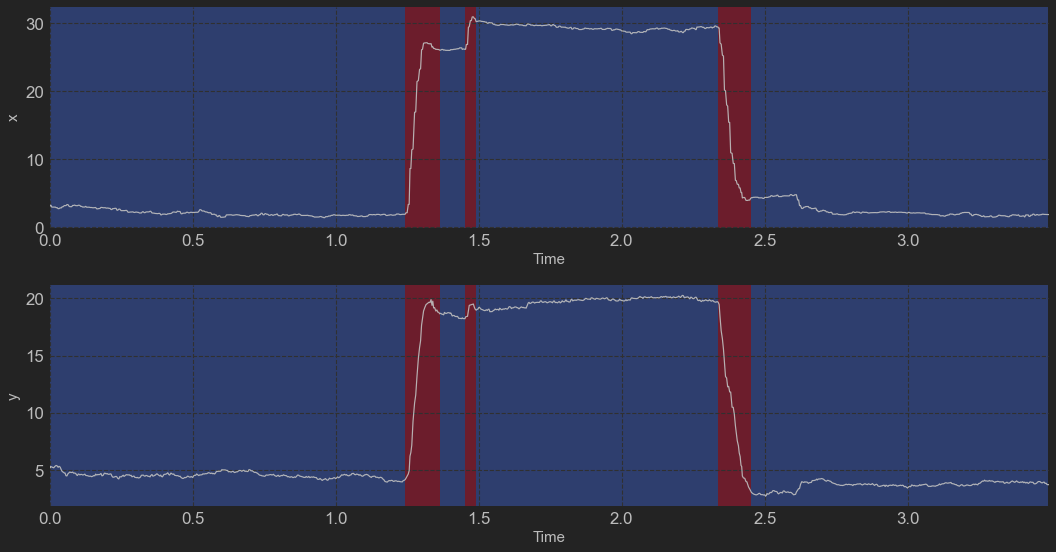

In [16]:
classifier.plot()

## IKF (Work In Progress)

Here, we employ a Two State Kalman Filter (TSKF), first described in *Komogortsev and Khan (2009)*. The TSKF models an eye as a system with two states: position and velocity. The acceleration of the eye is modeled as white noise with fixed maximum acceleration. When applied to the recorded eye position signal the TSKF generates predicted eye velocity signal. The values of the measured and predicted eye velocity allow employing Chi-square test to detect the onset and the offset of a saccade (*Sauter ,1991*).

In [17]:
t = eye['t']
x = eye['x_right']
y = eye['y_right']

In [18]:
%autoreload

classifier = IKF(t, x, y, threshold=1.)
classifier.process()

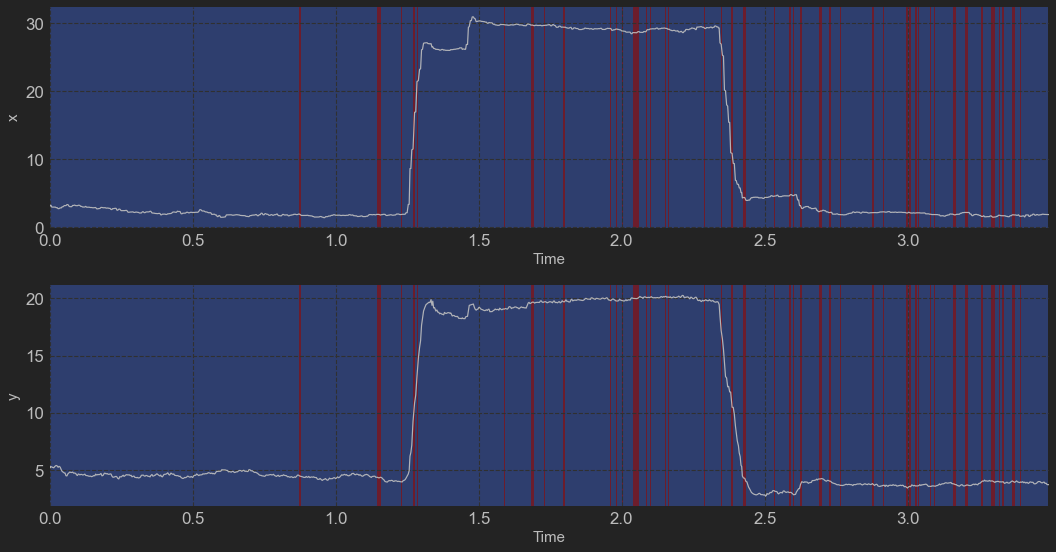

In [19]:
classifier.plot()

## I2MC

Described in _Hessels et. al. (2016)_. It is a fixation detection algorithm suited for a wide range of noise levels and when periods of data loss may be present, without the need to set a large number of parameters.
The I2MC algorithm is composed of three separate steps:

- Interpolation of missing data.
- Two-means clustering (i.e., the selection of fixation candidates by the search rule).
- Fixation labeling (the categorization rules).

**Interpolation**. Steffen's method is used (Steffen, 1990) if the segment with missing data is shorter than 100ms This value is not fixed and is a parameter of this model. Interpolation is monotonic and locally determined by the valid gaze samples at the beginning and the end of the interpolation window. Furthermore, at least two valid points of data must be present at the beginning and at the end of the interpolation window.

**Two means clustering**. A moving window of 200 ms width slides over the gaze position signal. The value of 200 ms was chosen here so that a window generally would contain parts of at most two, and no more, fixations. For each window, a two-means clustering procedure is carried out. Two-means cluster-ing is a variant of k-means clustering where $k = 2$.

**Fixation labelling**. A cutoff is used to determine fixation candidates from the clustering-weight signal. Here we used a cutoff of the mean clustering weight plus two standard deviations. All periods of clustering-weight signal below this cutoff are labeled as fixation candidates, and thereafter consecutive fixation candidates are merged. Finally, short fixation candidates are excluded from the output. Standard values are: merging fixation candidates that were less than $0.7^o$ apart and separated by less than $40$ ms and removing fixations shorter than $40$ ms were removed.


#### Eye Movements

In [20]:
t = eye['t']
x_r = eye['x_right']
y_r = eye['y_right']
x_l = eye['x_left']
y_l = eye['y_left']

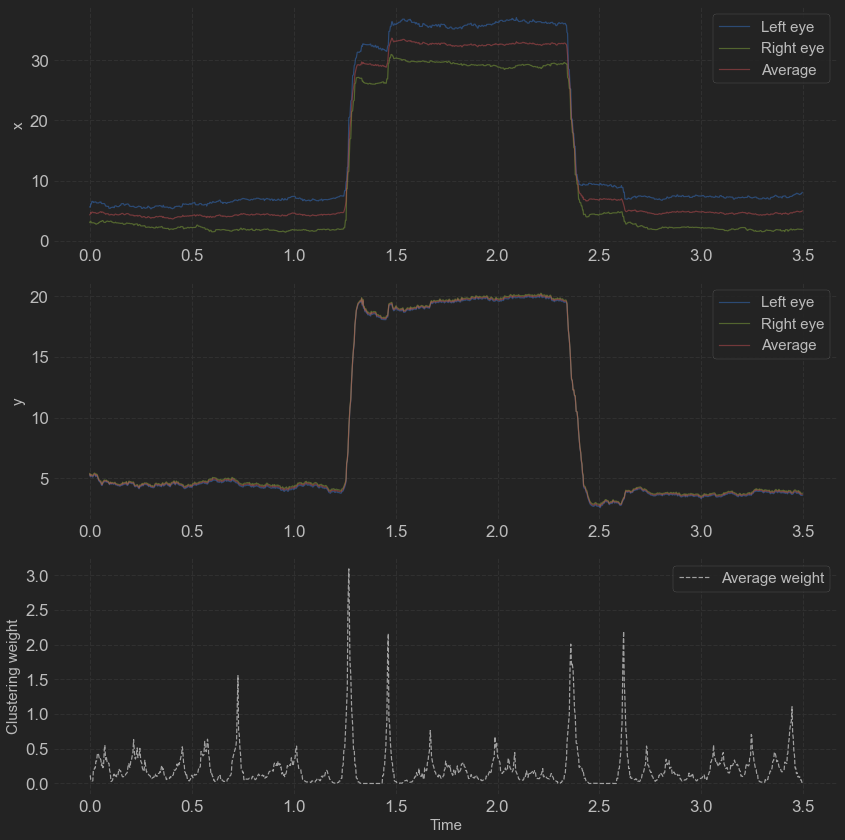

In [21]:
%autoreload

classifier = I2MC(t, type='binocular',x_l=x_l, y_l=y_l, x_r=x_r, y_r=y_r,
                  max_gap_duration=100, verbose=True,
                  window_length=300, step=2, n_iter=3, plot=True)
classifier.process()

In [22]:
classifier.get_results(threshold=0.8)

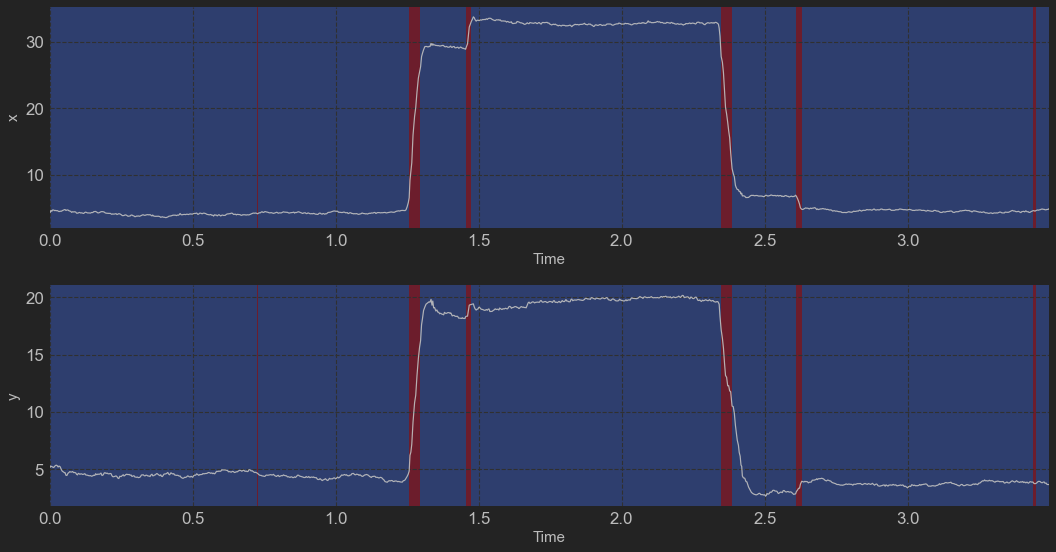

In [23]:
%autoreload

classifier.plot()

#### Gaze Movements

In [24]:
t = gaze['t']
x = gaze['x']
y = gaze['y']

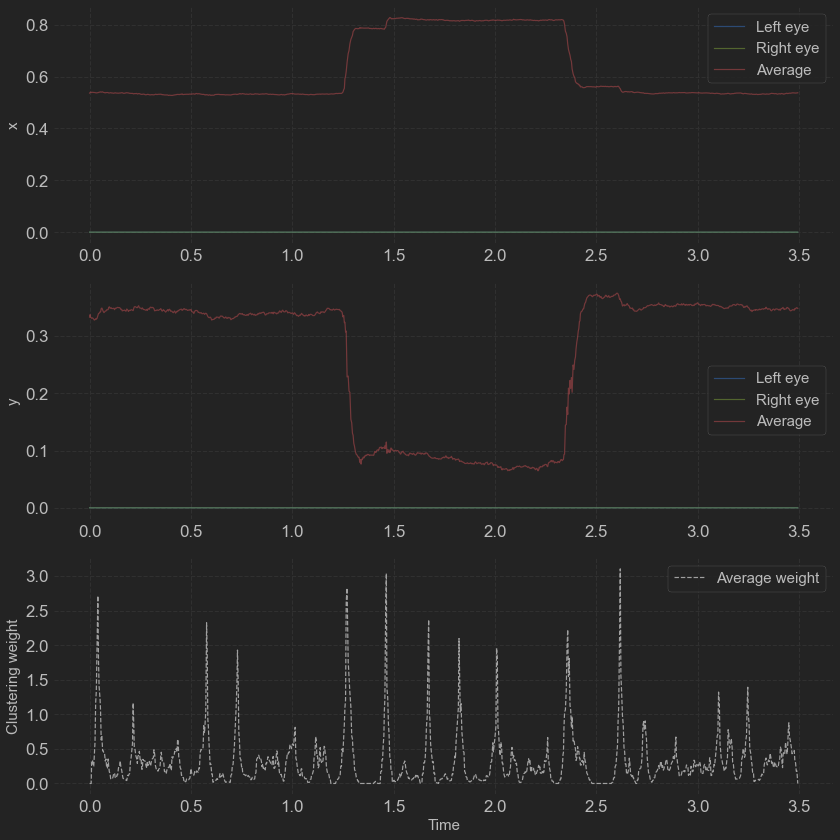

In [25]:
%autoreload

classifier = I2MC(t, type='monocular', x=x, y=y,
                  max_gap_duration=100, verbose=True,
                  window_length=200, step=2, n_iter=3, plot=True)

classifier.process()

In [26]:
classifier.get_results(threshold=0.8)

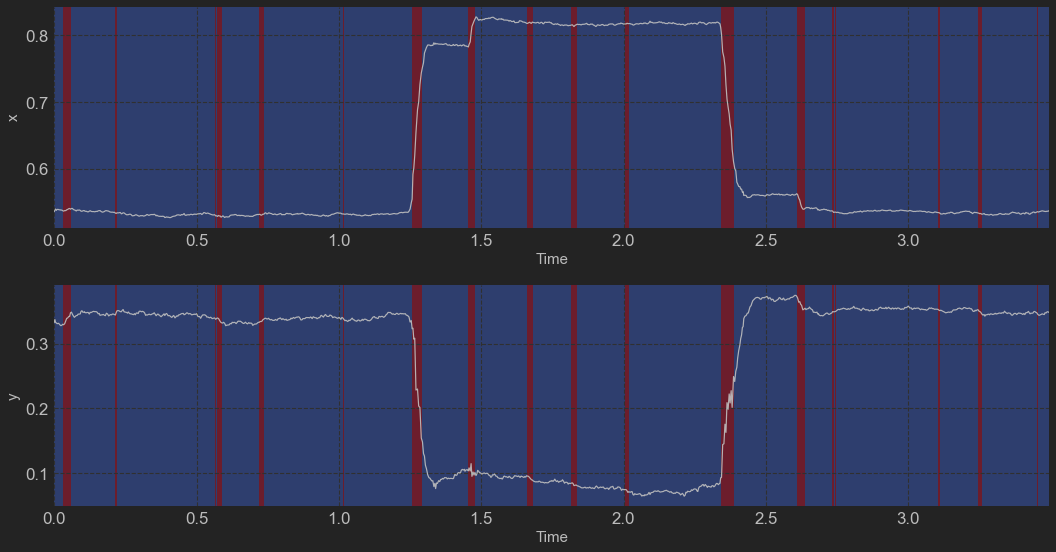

In [27]:
classifier.plot()

## NSLR-HMM

Described in _Pekkanen & Lappi (2017)_. It is a classification algorithm for the detection of fixations, saccades, smooth pursuits and post-saccadic oscillations.

This algorithm introduces the Naive Segmented Linear Regression (NSLR), a new method for eye-movement signal denoising and segmentation. The proposed method is based on the assumption that in most situations the gaze position signal is well approximated by a piecewise linear function, and events correspond to the pieces of such function. The method finds a piecewise linear function that approximately minimizes the approximation error, while taking into account prior knowledge of typical eye movement characteristics.

In [28]:
t = eye['t']
x = eye['x_right']
y = eye['y_right']

In [29]:
%autoreload

classifier = NSLR_HMM(t, x, y, optimize_noise=False)
classifier.process()

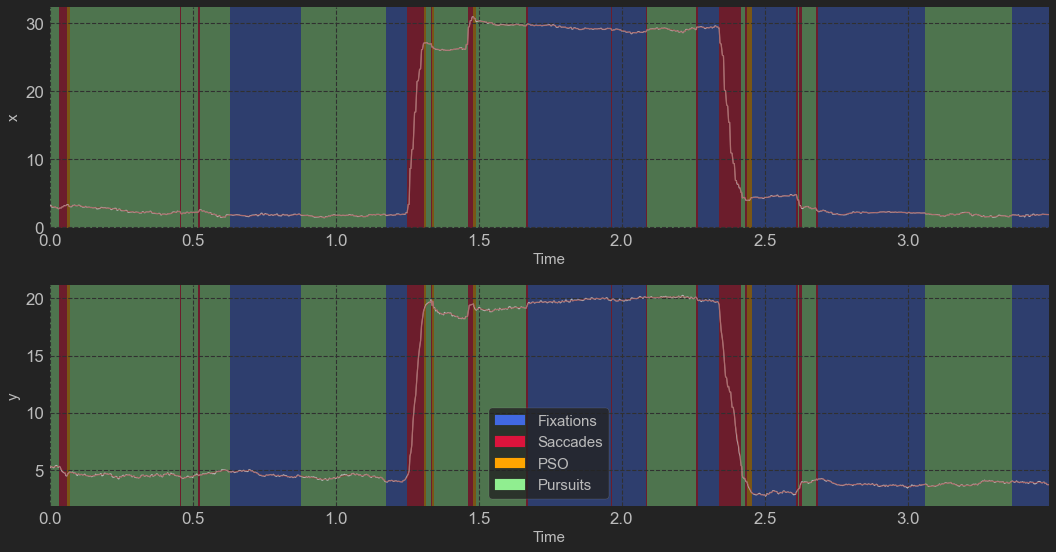

In [30]:
classifier.plot()

## ISF

Inspired by _Gibaldi & Sabatini (2020)_ and _Gibaldi et. al. (2015)_. This implementation contains a significant number of deviations or guesses from the original work because the authors did not share many details on their implementation.

This algorithm detects ocular saccades using a model fitting approach. First, the start and end points of each saccade is first roughly estimated using the IVT or IHMM algorithm. Then, using this time window, a better estimate of saccade parameters are found by fitting a sigmoid on the eye movement trace. However, not all points are taken into consideration to fit the model. A Random Sample Consensus (RANSAC) method is used to eliminate potential outliers.

In [31]:
t = eye['t']
x = eye['x_right']
y = eye['y_right']

In [32]:
%autoreload

classifier = ISF(t, x, y, threshold=45, n_iter=10, outlier_proba=0.1)
classifier.process()

Fitting the saccades: [##################################################] 100.0%
Finished! 3/3 saccades were fitted.


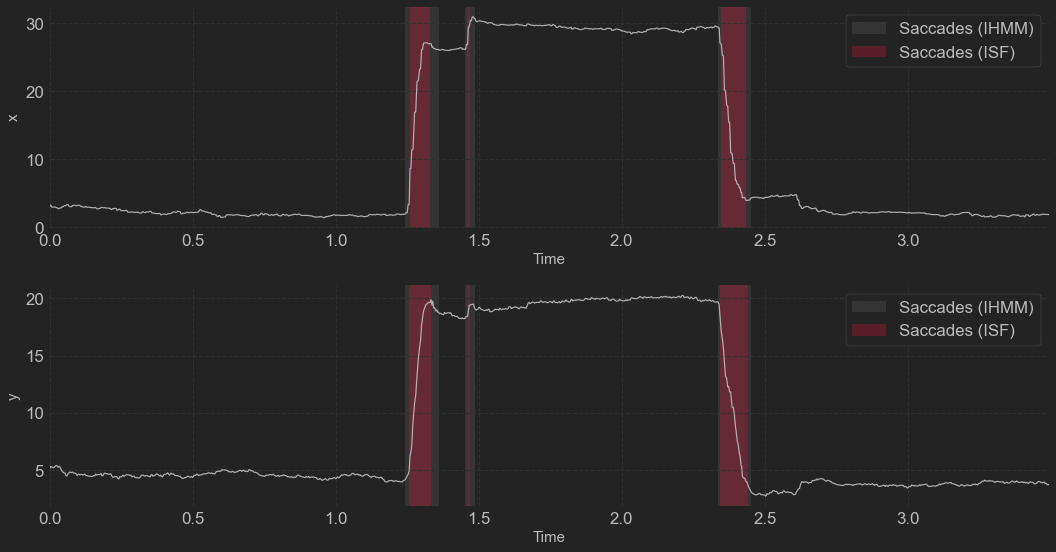

In [33]:
classifier.plot()

In [34]:
classifier.ihmm.stats()

Original probabilistic parameters: 
A = 
[[0.95 0.05]
 [0.05 0.95]]
B = 
[[0.9 0.1]
 [0.1 0.9]]

Re-estimated probabilistic parameters: 
A = 
[[0.99453009 0.00546991]
 [0.06728074 0.93271926]]
B = 
[[0.86533237 0.13466763]
 [0.16233782 0.83766218]]

Initial state distribution: 
P = [0.5 0.5]


------------------------------ * ------------------------------

Saccade parameters:
	* x component
		- Duration = 70.4 ms ; [1.259 - 1.330] s
		- Amplitude = 24.09 °
		- Peak velocity = 735.00 °/s
	* y component
		- Duration = 75.3 ms ; [1.258 - 1.333] s
		- Amplitude = 14.77 °
		- Peak velocity = 418.99 °/s



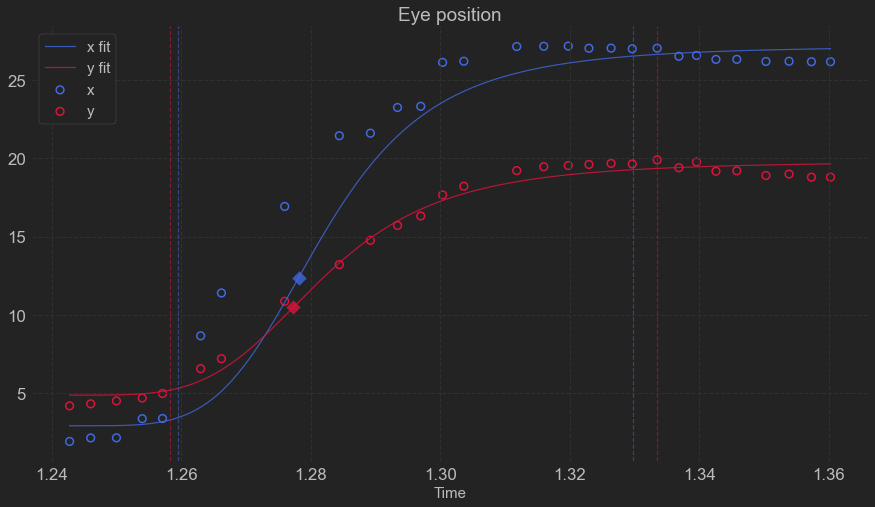

------------------------------ * ------------------------------

Saccade parameters:
	* x component
		- Duration = 9.2 ms ; [1.460 - 1.469] s
		- Amplitude = 4.29 °
		- Peak velocity = 945.04 °/s
	* y component
		- Duration = 10.8 ms ; [1.460 - 1.471] s
		- Amplitude = 1.09 °
		- Peak velocity = 201.22 °/s



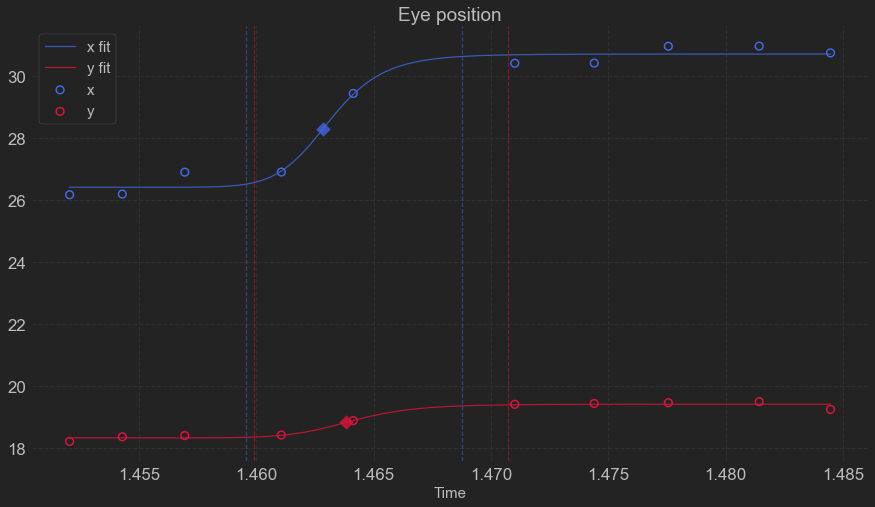

In [35]:
classifier.plot_saccades(n=2)

In [36]:
saccades = classifier.get_saccade_parameters()